# Store Item Demand Forecasting Challenge

https://www.kaggle.com/c/demand-forecasting-kernels-only/kernels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('train.csv')

First to get a 'feel' of the data, null values, size, and types

In [6]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df.date.min() , df.date.max()

('2013-01-01', '2017-12-31')

In [9]:
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

In [10]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [11]:
1826//365

5

No null values, 913k rows over 10 stores, 50 items and 1826 days (5 years), no need to prepare the data anymore except chagning the date to actual date) so on we go to some basic (and some less basic) analysis

In [12]:
df['date'] = pd.to_datetime(df['date'])

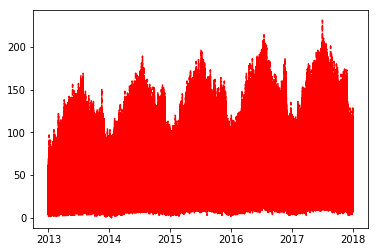

In [10]:
plt.plot(df.date , df.sales, 'r--')

Each 'bump' last for 1 year

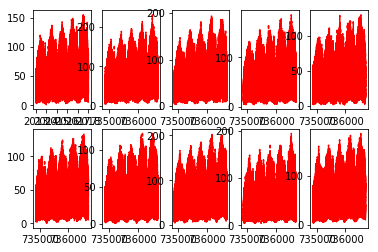

In [11]:
for store in range(df.store.nunique()):
    m = df.store == store+1
    plt.subplot(2,5,store+1)
    plt.plot(df.date.where(m), df.sales.where(m), 'r--')

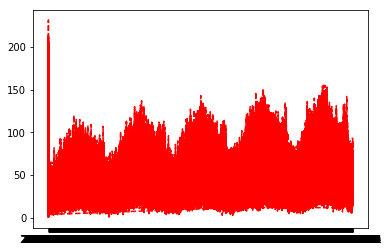

In [37]:
plt.plot(df.date.where(s), df.sales, 'r--')

Trend is similar in all stores (my guess is data is artificial) nevertheless all is left is prediction, i'll use a Prophet over the classic ARIMA model which is a bit difficult to handle.

# Prophet

In [14]:
from fbprophet import Prophet

In [71]:
reg = Prophet(daily_seasonality=True)

Prophet requires 2 columns 'ds' - dataseries , and 'y' - values , since we saw there is no variance per store or per item i can aggregate the sales value for each day and remove store and item values. 

In [72]:
df1 = df.drop(['store','item'],axis=1)

In [73]:
df1 = df1.groupby(['date']).sum()

In [74]:
df1.head(1)

,sales
date,
2013-01-01,13696


In [75]:
d = df.date == '2013-01-01'
df.sales.where(d).sum()

13696.0

A small check to see i did everything correct , and thats it , ill change the names to ds and y and continue.

In [78]:
df1 = df1.reset_index()
df1 = df1.rename(columns={'date': 'ds', 'sales': 'y'})
df1.head(0)

,index,ds,y


In [79]:
reg.fit(df1)

C:\Users\ori\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [89]:
future = reg.make_future_dataframe(periods=90) 
future.tail()

,ds
1911,2018-03-27
1912,2018-03-28
1913,2018-03-29
1914,2018-03-30
1915,2018-03-31


In [90]:
forecast = reg.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1911,2018-03-27,27576.347223,26081.799695,29066.401839
1912,2018-03-28,27774.265385,26289.390635,29348.575824
1913,2018-03-29,29584.683860,28248.116329,31153.596497
1914,2018-03-30,31440.995056,29871.717603,32988.115597
1915,2018-03-31,33338.994133,31909.209916,34899.357146


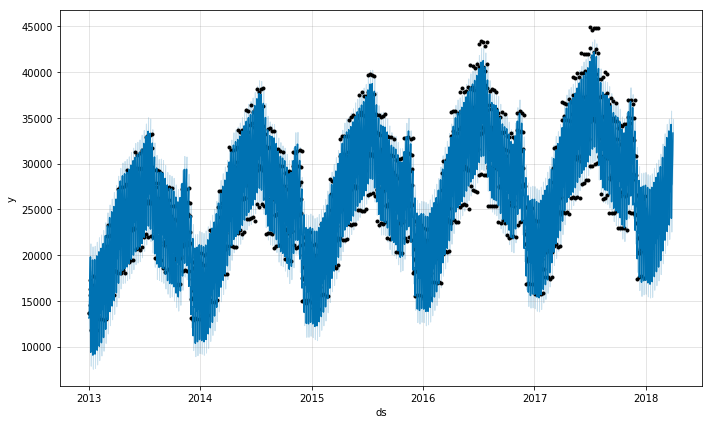

In [91]:
fig1 = reg.plot(forecast)

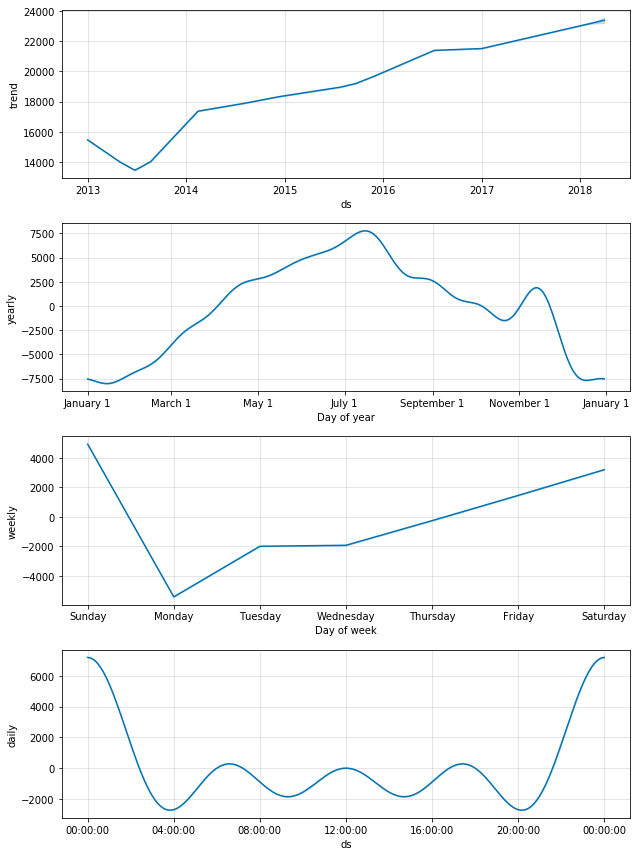

In [92]:
fig2 = reg.plot_components(forecast)